In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
from IPython.display import Image
from qutip import *
import pickle
import time

import sympy
import numpy as np
from sympy import Sum, summation
from sympy.physics.wigner import wigner_3j
import math
import sys

In [2]:
w0rs = np.linspace(0.1,2.5,15)

with open("8L_Doppler_line_0707.txt","rb") as fp:
    sim_results = pickle.load(fp)
    
with open("8L_Doppler_line_0717.txt","rb") as fp:
    sim_resultsoLD = pickle.load(fp)

w_s_iLD, w_s_oLD, w_r_iLD, w_r_oLD = [], [], [], []
P_s_iLD, P_s_oLD, P_r_iLD, P_r_oLD = [], [], [], []

for i in range(15):
    w0r = np.linspace(0.1,2.5,15)[i]
    result = sim_results.get('s_'+"iLD")[i]
    w_s_iLD.append(result[4])
    P_s_iLD.append(result[2][-1])
    nss_s = np.array(sim_results.get('s_'+"nss"))

    result = sim_resultsoLD.get('s_'+"oLD"+str(i))
    w_s_oLD.append(result[4])
    P_s_oLD.append(result[2][-1])

    result = sim_results.get('r_'+"iLD")[i]
    w_r_iLD.append(result[4])
    P_r_iLD.append(result[2][-1])
    nss_r = np.array(sim_results.get('r_'+"nss"))

    result = sim_resultsoLD.get('r_'+"oLD"+str(i))
    w_r_oLD.append(result[4])
    P_r_oLD.append(result[2][-1])

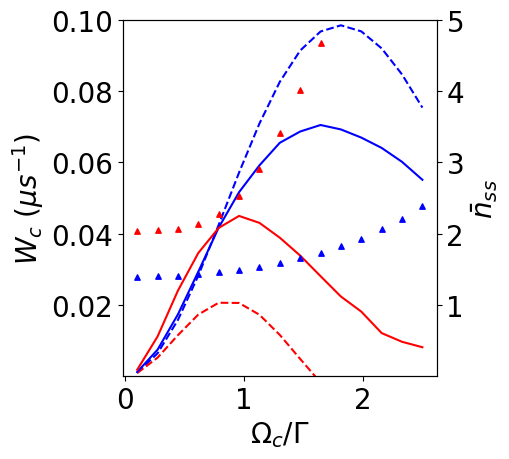

In [3]:
plt.rcParams.update({'font.size':20})
fig, axL = plt.subplots( figsize=(5.5, 5), sharex = True, sharey = True)
axL.plot(w0rs, w_s_iLD, "--", color = "blue", label="SW n = 5")
axL.plot(w0rs, w_r_iLD, "--", color = "red", label="RW n = 5")
axL.plot(w0rs, w_s_oLD, "-", color = "blue", label="SW n = 50")
axL.plot(w0rs, w_r_oLD, "-", color = "red", label="RW n = 50")
axL.set_ylim(0,0.1) 
axL.set_yticks((0.02, 0.04, 0.06, 0.08, 0.10)) 
axL.set_ylabel("$W_c$ ($\mu s^{-1}$)")
axL.set_xlabel("$\Omega_c/\Gamma$")
#axL.legend(loc = 2)

axL2 = axL.twinx()  # instantiate a second axes that shares the same x-axis
axL2.scatter(w0rs, nss_s, color="blue", marker = "^", s = 15,  label="SW")
axL2.scatter(w0rs, nss_r, color="red", marker = "^", s = 15, label="RW")
axL2.set_ylim(0,5)
axL2.set_yticks([1,2,3,4,5]) 
axL2.set_ylabel(r"$\bar{n}_{ss}$")
axL2.tick_params(axis='y')

fig.tight_layout()
#plt.savefig('8L_Dopplercomp.pdf', bbox_inches = 'tight')

In [5]:
hbar = 1.05457182E-34
Gamma = 2 * np.pi * 21.5
gamma = Gamma/2
Gammas = [2 * np.pi * 21.5, 2 * np.pi * 1.5]
wm = 2*np.pi*2
eta_0 = 2*np.pi/(397E-9)*np.sqrt(hbar/(2 * 39.9625908E-3/6.022E23 *wm *1E6))
eta_1 = 2*np.pi/(866E-9)*np.sqrt(hbar/(2 * 39.9625908E-3/6.022E23 *wm *1E6))

n0 = 70
N    = 150                # Maximam motional quantum number
n_int = N               # Number of interaction terms
n_col = N              # Number of collapse terms
n_steps = 500

a = tensor(qeye(8), destroy(N))
R = a.dag() + a

n0_thermal = thermal_dm(N,n0)
ex_op = tensor(qeye(8), destroy(N))

# S-1/2 |0>, S+1/2 |1>, \ D-3/2 |2>, D-1/2 |3>, D+1/2 |4>, D+3/2 |5>, \ P-1/2 |6>, P+1/2 |7>

S_op = tensor(basis(8,0) * basis(8,0).dag()+basis(8,1) * basis(8,1).dag(), qeye(N))
P_op = tensor(basis(8,6) * basis(8,6).dag()+basis(8,7) * basis(8,7).dag(), qeye(N))
D_op = tensor(basis(8,2) * basis(8,2).dag()+basis(8,3) * basis(8,3).dag()+basis(8,4) * basis(8,4).dag()+basis(8,5) * basis(8,5).dag(), qeye(N))

tlist = np.linspace(0, 200, 500)

In [6]:
ex_sw, S_sw, P_sw, D_sw = np.zeros(500), np.zeros(500), np.zeros(500), np.zeros(500)
ex_rw, S_rw, P_rw, D_rw = np.zeros(500), np.zeros(500), np.zeros(500), np.zeros(500)

with open("tevolve_0709.txt","rb") as fp:
        t_results = pickle.load(fp)
        
for i in range(150):
    n0_thermal_coeff = n0_thermal[i,i].real
        
    output_sw = t_results.get("s"+str(i))
    ex_sw = ex_sw + output_sw.expect[0] * n0_thermal_coeff
    S_sw = S_sw + output_sw.expect[1] * n0_thermal_coeff
    P_sw = P_sw + output_sw.expect[2] * n0_thermal_coeff
    D_sw = D_sw + output_sw.expect[3] * n0_thermal_coeff

    output_rw = t_results.get("r"+str(i))
    ex_rw = ex_rw + output_rw.expect[0] * n0_thermal_coeff
    S_rw = S_rw + output_rw.expect[1] * n0_thermal_coeff
    P_rw = P_rw + output_rw.expect[2] * n0_thermal_coeff
    D_rw = D_rw + output_rw.expect[3] * n0_thermal_coeff

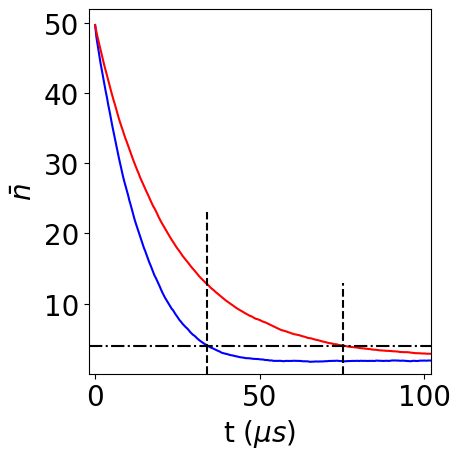

In [7]:
plt.rcParams.update({"font.size" : 20})
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel(r"$\bar{n}$")
#axs[0].plot(tlist, result[0], color = "blue", label="MCsolve 1")
ax.plot(tlist, ex_sw, color = "blue", label="SW")
ax.plot(tlist, ex_rw, color = "red", label="RW")
ax.axhline(y=4, color='black', linestyle='-.', label=r"$\bar{n}=4$")

#ax.legend()
ax.plot([34.07,34.07],[0,23], color='black', linestyle='--')
ax.plot([75.35,75.35],[0,13], color='black', linestyle='--')

ax.set_yticks([10,20,30,40,50])

ax.set_ylim([0, 52])
ax.set_xlim([-2, 102])

ax.set_xlabel(r"t ($\mu s$)")

fig.tight_layout()